In [16]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from fittingtask import FittingTask
import modelfitting as mf
import os
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))
c = 2.99792e5 # km/s

In [2]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_2M0036/SDCK*.spec_a0v.fits'))

fluxes = []
wls = []
for filename in filelist:
    hdu = fits.open(filename)
    flux = hdu[0].data
    wl = hdu[1].data

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    fluxes.append(flux)
    wls.append(wl)

dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

# remove first order with all NaNs when making various arrays
obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2
wind = np.isinf(wfobs0)
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :]

First lets fit wcoeffs.

In [44]:
norders=20
lam_obs = []
wcoefs_ori = []
for jj in range(norders):
    NPW = 4  # NPW = number of wavelength coeffs -> TODO: rename to NUM_WAVELEN_COEFFS
    npix = dims[2]
    pix = np.arange(npix, dtype=float)/npix # 1024 points between [0,1) -> relative pixel number
    wcoef_ori = np.polyfit(pix, wls[0, jj, :], NPW-1) # wcoef = wavelength solution coefficients
    lam = np.polyval(wcoef_ori, pix)
    lam_obs.append(lam)
    wcoefs_ori.append(list(wcoef_ori))

Then lets use wcoeffs from chi-sq fitting.

In [34]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_stacked_*-5.*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')

lam_fitted = []    
for jj in range(norders):
    wcoef = [float(i) for i in results['wcoef'][jj].split(',')]
    lam = np.polyval(wcoef, pix)
    lam_fitted.append(lam)

In [43]:
wcoef_ori

array([ 1.00645638e-04, -3.03001813e-03,  2.73788381e-02,  1.94786808e+00])

In [52]:
chiplams = []
chipmods = []

chiplams_oriwl = []
chipmods_oriwl = []

for jj in range(norders):
    modelpath = f"{homedir}/uoedrive/data/BTSettltemp/lte015.0-5.0-0.0a+0.0.BT-Settl.spec.fits"
    model = Table.read(modelpath, format='fits')
    modelname = modelpath.split("/")[-1]
    model['wl'] = model['Wavelength']
    model['flux'] = model['Flux']
    lolim = wls[:, jj, :].min() - 0.003
    hilim = wls[:, jj, :].max() + 0.003
    tind = (model['wl']>lolim) * (model['wl'] < hilim)
    lam_template = model['wl'][tind]
    template = model['flux'][tind]
    template /= np.median(template)
    NPC=2

    wcoef = [float(i) for i in results['wcoef'][jj].split(',')]
    ccoef = [float(i) for i in results['ccoef'][jj].split(',')]
    mymod, myw = mf.modelspec_template(
        [results['vsini'][jj], results['lld'][jj], results['rv'][jj]] + wcoef + ccoef,
        lam_template,
        template,
        NPW,
        NPC,
        npix,
        retlam=True)
    chiplams.append(myw)
    chipmods.append(mymod)

    mymod, myw = mf.modelspec_template(
        [results['vsini'][jj], results['lld'][jj], results['rv'][jj]] + wcoefs_ori[jj] + ccoef,
        lam_template,
        template,
        NPW,
        NPC,
        npix,
        retlam=True)
    chiplams_oriwl.append(myw)
    chipmods_oriwl.append(mymod)

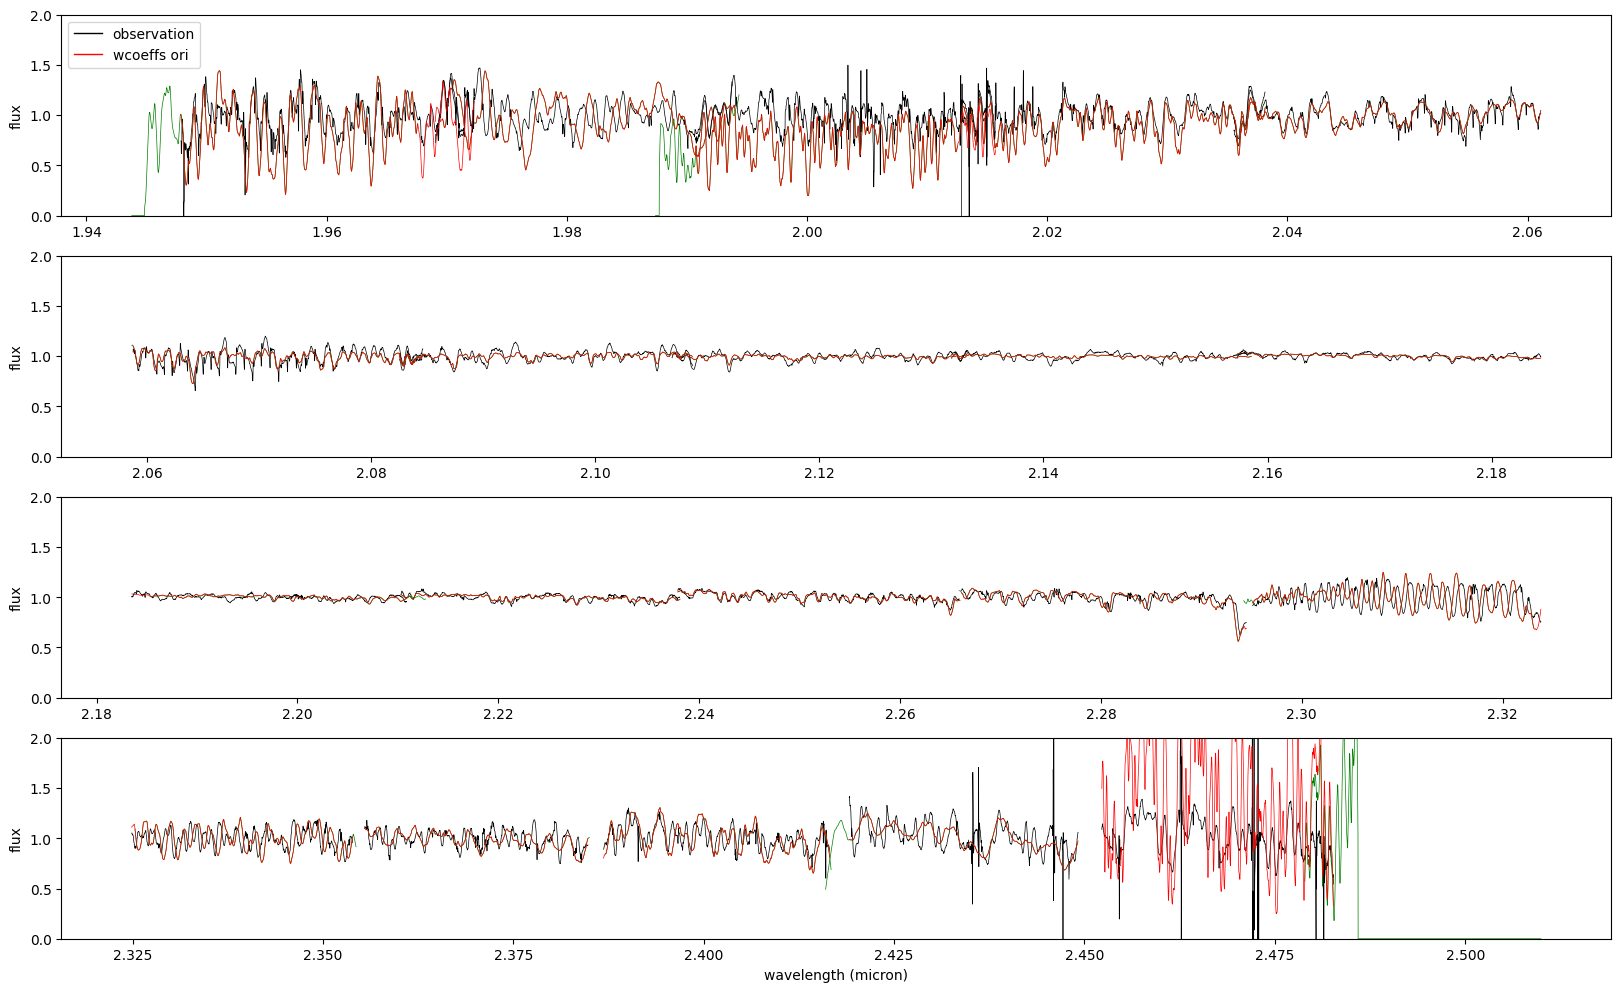

In [55]:
model = 'lte015.0-5.0'
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(lam_obs[jj], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        #plt.plot(lam_fitted[jj], fobs[jj,:], linewidth=0.5, color="r", label="fitted wcoeffs")
        plt.plot(chiplams[jj], chipmods[jj], linewidth=0.5, color="green")
        plt.plot(chiplams_oriwl[jj], chipmods_oriwl[jj], linewidth=0.5, color="red")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),]
                        #Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "wcoeffs ori"], loc=2)